## Импорт библиотек, объявление пользовательских функций

In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold

from sklearn.base import clone

from sklearn.pipeline import make_pipeline

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split, cross_validate

from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from catboost import CatBoostClassifier

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split, cross_validate

from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve, auc, f1_score, precision_score, recall_score
from sklearn.utils import class_weight

import itertools

import optuna
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import HistGradientBoostingClassifier

from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import RidgeClassifier, SGDClassifier, LogisticRegression
from sklearn.naive_bayes import BernoulliNB, GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.svm import LinearSVC, NuSVC, SVC
from xgboost import XGBClassifier
from datetime import datetime

In [2]:
# Описываем пользовательские функции

# Функция для вывода confusion_matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues): 
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes) 
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Функция принимает фактическое и прогнозное значения и выводит ряд метрик качества модели
# можно указать порог, по умолчанию он равен 0.5
def metrics(fact, pred, trash=0.5):
    plot_confusion_matrix(confusion_matrix(fact, pred > trash), ['0','1'])
    print('precision:', precision_score(fact, pred > trash))
    print('recall:', recall_score(fact, pred > trash))
    print('f1_score:', f1_score(fact, pred > trash))    
    print('accuracy_score:', accuracy_score(fact, pred > trash))
    print('roc_auc:', roc_auc_score(fact, pred))

## Читаем файл с тренировочными данными, изучаем признаки

In [3]:
train = pd.read_csv('train.csv', index_col='id')
print(train.shape)

cols = []
for cl in train.columns:
    cols.append(cl.lower().replace(' ', '_'))
    
train.columns = cols
train.head()

(159256, 23)


,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,relaxation,...,hdl,ldl,hemoglobin,urine_protein,serum_creatinine,ast,alt,gtp,dental_caries,smoking
id,,,,,,,,,,,,,,,,,,,,,
0,55,165,60,81.0,0.5,0.6,1,1,135,87,...,40,75,16.5,1,1.0,22,25,27,0,1
1,70,165,65,89.0,0.6,0.7,2,2,146,83,...,57,126,16.2,1,1.1,27,23,37,1,0
2,20,170,75,81.0,0.4,0.5,1,1,118,75,...,45,93,17.4,1,0.8,27,31,53,0,1
3,35,180,95,105.0,1.5,1.2,1,1,131,88,...,38,102,15.9,1,1.0,20,27,30,1,0
4,30,165,60,80.5,1.5,1.0,1,1,121,76,...,44,93,15.4,1,0.8,19,13,17,0,1


In [5]:
# Проверим наличие пропусков

# Если пропуски есть - визуализируем их распределение по признакам
# красный - пропущенные данные, серый - ок


# Расчет количества и доли пропусков
miss = train.isna().sum().sum()
print('Missing Values:', miss)

if miss > 0:
    
    plt.figure(figsize=(10,6))
    sns.heatmap(train.isnull(), cmap=sns.color_palette(['#c0c0c0', '#ff0000']))
    
    for col in train.columns:
        miss = train[col].isna().sum()
        if miss > 0:
            print(f'В столбце {col} пропущенных значений {miss}. Доля пропусков {(miss/train.shape[0]*100):5.2f}%')

# Проверка наличия дубликатов в данных
print('Duplicates in Data:', train.duplicated().sum())

Missing Values: 0
Duplicates in Data: 0


Пропусков и дубликатов в данных не обнаружено

In [6]:
# Оценим баланс классов
train.smoking.sum() / len(train)

0.4373649972371528

In [7]:
train.dtypes

age                      int64
height(cm)               int64
weight(kg)               int64
waist(cm)              float64
eyesight(left)         float64
eyesight(right)        float64
hearing(left)            int64
hearing(right)           int64
systolic                 int64
relaxation               int64
fasting_blood_sugar      int64
cholesterol              int64
triglyceride             int64
hdl                      int64
ldl                      int64
hemoglobin             float64
urine_protein            int64
serum_creatinine       float64
ast                      int64
alt                      int64
gtp                      int64
dental_caries            int64
smoking                  int64
dtype: object

Все признаки числовые.

Посмотрим на их характеристики.

In [4]:
x = train.drop('smoking', axis=1)
y = train.smoking

In [9]:
x.describe().T

,count,mean,std,min,25%,50%,75%,max
age,159256.0,44.306626,11.842286,20.0,40.0,40.0,55.0,85.0
height(cm),159256.0,165.266929,8.818970,135.0,160.0,165.0,170.0,190.0
weight(kg),159256.0,67.143662,12.586198,30.0,60.0,65.0,75.0,130.0
waist(cm),159256.0,83.001990,8.957937,51.0,77.0,83.0,89.0,127.0
eyesight(left),159256.0,1.005798,0.402113,0.1,0.8,1.0,1.2,9.9
eyesight(right),159256.0,1.000989,0.392299,0.1,0.8,1.0,1.2,9.9
hearing(left),159256.0,1.023974,0.152969,1.0,1.0,1.0,1.0,2.0
hearing(right),159256.0,1.023421,0.151238,1.0,1.0,1.0,1.0,2.0
systolic,159256.0,122.503648,12.729315,77.0,114.0,121.0,130.0,213.0
relaxation,159256.0,76.874071,8.994642,44.0,70.0,78.0,82.0,133.0


In [10]:
# Посмотрим, есть ли признаки, похожие на категориальные

x.nunique()

age                     18
height(cm)              14
weight(kg)              28
waist(cm)              531
eyesight(left)          20
eyesight(right)         17
hearing(left)            2
hearing(right)           2
systolic               112
relaxation              75
fasting_blood_sugar    229
cholesterol            227
triglyceride           392
hdl                    108
ldl                    222
hemoglobin             134
urine_protein            6
serum_creatinine        28
ast                    140
alt                    188
gtp                    362
dental_caries            2
dtype: int64

## Разбиваем данные на train и test, запускаем классификаторы с параметрами по умолчанию, выбираем модели для дальнейшей настройки

In [5]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state = 42, stratify=y)


cw = list(class_weight.compute_class_weight(class_weight='balanced',
                                            classes=np.unique(y_train), 
                                            y=y_train
                                           )
         )

In [12]:
%%time

classifiers = {}
classifiers['AdaBoostClassifier'] = [AdaBoostClassifier()]
classifiers['BaggingClassifier'] = [BaggingClassifier(n_jobs=7)]
classifiers['ExtraTreesClassifier'] = [ExtraTreesClassifier(n_jobs=7, class_weight='balanced')]
classifiers['GradientBoostingClassifier'] = [GradientBoostingClassifier()]
classifiers['RandomForestClassifier'] = [RandomForestClassifier(n_jobs=7, class_weight='balanced')]
classifiers['MLPClassifier'] = [MLPClassifier()]
classifiers['SGDClassifier'] =[SGDClassifier(loss='log_loss', n_jobs=7, class_weight='balanced')]
classifiers['XGBClassifier'] = [XGBClassifier(n_jobs=7)]
classifiers['LogisticRegression'] = [LogisticRegression(n_jobs=7, class_weight='balanced')]
classifiers['CatBoostClassifier'] = [CatBoostClassifier(class_weights=cw)]
classifiers['HistGradientBoostingClassifier'] = [HistGradientBoostingClassifier()]
classifiers['DecisionTreeClassifier'] = [DecisionTreeClassifier()]
classifiers['RidgeClassifier'] = [RidgeClassifier()]
classifiers['BernoulliNB'] = [BernoulliNB()]
classifiers['GaussianNB'] = [GaussianNB()]
classifiers['KNeighborsClassifier'] = [KNeighborsClassifier()]
classifiers['LinearDiscriminantAnalysis'] = [LinearDiscriminantAnalysis()]
classifiers['QuadraticDiscriminantAnalysis'] = [QuadraticDiscriminantAnalysis()]
classifiers['LinearSVC'] = [LinearSVC()]
classifiers['LGBMClassifier'] = [LGBMClassifier()]



result = pd.DataFrame(columns=['name', 'speed', 'result_mean', 'result_std'])

print('Start Modeling', datetime.now().strftime("%H:%M:%S"))

for cl in classifiers.keys():
    start_time = datetime.now()
    cv_score = cross_val_score(classifiers[cl][0],
                               x_train,
                               y_train,
                               n_jobs=-1,
                               cv=4, 
                               scoring="roc_auc", 
                               verbose=False
                              )
    
    stop_time = datetime.now()
    result.loc[len(result.index)] = [cl, (stop_time-start_time).seconds, np.mean(cv_score), np.std(cv_score)]    
    print(datetime.now().strftime("%H:%M:%S"), cl, 'ok')

Start Modeling 20:51:10
20:51:22 AdaBoostClassifier ok
20:51:32 BaggingClassifier ok
20:51:50 ExtraTreesClassifier ok
20:52:18 GradientBoostingClassifier ok
20:52:34 RandomForestClassifier ok
20:53:00 MLPClassifier ok
20:53:00 SGDClassifier ok
20:53:09 XGBClassifier ok
20:53:11 LogisticRegression ok
20:53:57 CatBoostClassifier ok
20:54:03 HistGradientBoostingClassifier ok
20:54:05 DecisionTreeClassifier ok
20:54:05 RidgeClassifier ok
20:54:06 BernoulliNB ok
20:54:06 GaussianNB ok
20:55:23 KNeighborsClassifier ok
20:55:24 LinearDiscriminantAnalysis ok
20:55:25 QuadraticDiscriminantAnalysis ok
20:56:05 LinearSVC ok
20:56:10 LGBMClassifier ok
Wall time: 4min 59s


In [13]:
result.sort_values('result_mean', ascending=False)

,name,speed,result_mean,result_std
9,CatBoostClassifier,46,0.867050,0.001158
19,LGBMClassifier,5,0.864282,0.001057
10,HistGradientBoostingClassifier,5,0.863932,0.001265
7,XGBClassifier,8,0.862523,0.000852
3,GradientBoostingClassifier,27,0.858828,0.001204
4,RandomForestClassifier,15,0.854963,0.000891
2,ExtraTreesClassifier,18,0.851807,0.001501
0,AdaBoostClassifier,11,0.850826,0.000990
5,MLPClassifier,26,0.836546,0.002526
12,RidgeClassifier,0,0.832969,0.002122


In [14]:
transformer = FunctionTransformer(np.log1p, validate=True)

x_train_log = pd.DataFrame(transformer.transform(x_train), columns=x_train.columns)
x_test_log = pd.DataFrame(transformer.transform(x_test), columns=x_test.columns)

In [15]:
%%time

classifiers = {}
classifiers['AdaBoostClassifier'] = [AdaBoostClassifier()]
classifiers['BaggingClassifier'] = [BaggingClassifier(n_jobs=7)]
classifiers['ExtraTreesClassifier'] = [ExtraTreesClassifier(n_jobs=7, class_weight='balanced')]
classifiers['GradientBoostingClassifier'] = [GradientBoostingClassifier()]
classifiers['RandomForestClassifier'] = [RandomForestClassifier(n_jobs=7, class_weight='balanced')]
classifiers['MLPClassifier'] = [MLPClassifier()]
classifiers['SGDClassifier'] =[SGDClassifier(loss='log_loss', n_jobs=7, class_weight='balanced')]
classifiers['XGBClassifier'] = [XGBClassifier(n_jobs=7)]
classifiers['LogisticRegression'] = [LogisticRegression(n_jobs=7, class_weight='balanced')]
classifiers['CatBoostClassifier'] = [CatBoostClassifier(class_weights=cw)]
classifiers['HistGradientBoostingClassifier'] = [HistGradientBoostingClassifier()]
classifiers['DecisionTreeClassifier'] = [DecisionTreeClassifier()]
classifiers['RidgeClassifier'] = [RidgeClassifier()]
classifiers['BernoulliNB'] = [BernoulliNB()]
classifiers['GaussianNB'] = [GaussianNB()]
classifiers['KNeighborsClassifier'] = [KNeighborsClassifier()]
classifiers['LinearDiscriminantAnalysis'] = [LinearDiscriminantAnalysis()]
classifiers['QuadraticDiscriminantAnalysis'] = [QuadraticDiscriminantAnalysis()]
classifiers['LinearSVC'] = [LinearSVC()]
classifiers['LGBMClassifier'] = [LGBMClassifier()]



result_log = pd.DataFrame(columns=['name', 'speed', 'result_mean', 'result_std'])

print('Start Modeling', datetime.now().strftime("%H:%M:%S"))

for cl in classifiers.keys():
    start_time = datetime.now()
    cv_score = cross_val_score(classifiers[cl][0],
                               x_train_log,
                               y_train,
                               n_jobs=-1,
                               cv=4, 
                               scoring="roc_auc", 
                               verbose=False
                              )
    
    stop_time = datetime.now()
    result_log.loc[len(result_log.index)] = [cl, (stop_time-start_time).seconds, np.mean(cv_score), np.std(cv_score)]    
    print(datetime.now().strftime("%H:%M:%S"), cl, 'ok')

Start Modeling 20:57:18
20:57:24 AdaBoostClassifier ok
20:57:33 BaggingClassifier ok
20:57:51 ExtraTreesClassifier ok
20:58:18 GradientBoostingClassifier ok
20:58:36 RandomForestClassifier ok
20:59:30 MLPClassifier ok
20:59:31 SGDClassifier ok
20:59:40 XGBClassifier ok
20:59:42 LogisticRegression ok
21:00:27 CatBoostClassifier ok
21:00:32 HistGradientBoostingClassifier ok
21:00:34 DecisionTreeClassifier ok
21:00:34 RidgeClassifier ok
21:00:34 BernoulliNB ok
21:00:35 GaussianNB ok
21:01:52 KNeighborsClassifier ok
21:01:53 LinearDiscriminantAnalysis ok
21:01:54 QuadraticDiscriminantAnalysis ok
21:02:34 LinearSVC ok
21:02:37 LGBMClassifier ok
Wall time: 5min 19s


In [16]:
result_log.sort_values('result_mean', ascending=False)

,name,speed,result_mean,result_std
9,CatBoostClassifier,45,0.867059,0.001153
19,LGBMClassifier,2,0.864282,0.001057
10,HistGradientBoostingClassifier,4,0.863968,0.000869
7,XGBClassifier,9,0.862522,0.000854
3,GradientBoostingClassifier,26,0.858828,0.001203
4,RandomForestClassifier,18,0.855119,0.000506
2,ExtraTreesClassifier,18,0.853304,0.001254
0,AdaBoostClassifier,6,0.850826,0.000990
5,MLPClassifier,53,0.846050,0.001161
18,LinearSVC,40,0.842719,0.001510


## Поработаем с настройкой моделей, показавших хорошие результаты по умолчанию

## LGBMClassifier

[LightGBM] [Info] Number of positive: 48757, number of negative: 62722
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015155 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2114
[LightGBM] [Info] Number of data points in the train set: 111479, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.437365 -> initscore=-0.251863
[LightGBM] [Info] Start training from score -0.251863
precision: 0.7177579574755886
recall: 0.8125957120980092
f1_score: 0.7622382331156151
accuracy_score: 0.7782824371559537
roc_auc: 0.8631330564299247
Wall time: 1.22 s


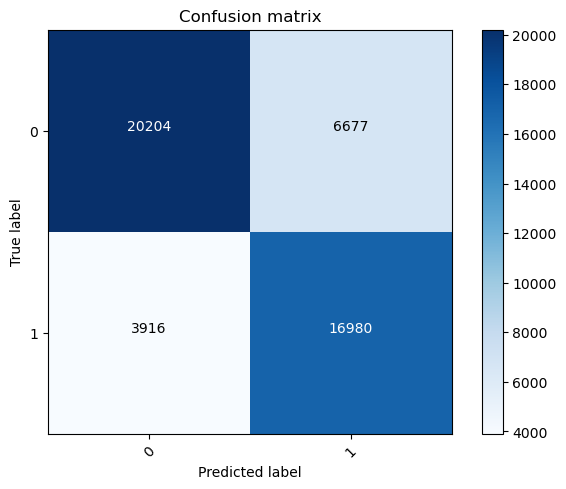

In [17]:
%%time

model = LGBMClassifier()
model.fit(x_train, y_train)
test_pred = model.predict_proba(x_test)[:,1]
metrics(y_test, test_pred)

In [18]:
%%time

def objective(trial):    
    params = {
            "objective": "binary",
            "verbosity": -1,
#             "boosting_type": "gbdt",
#             "boosting_type": trial.suggest_categorical("class_weight", ["gbdt", "dart", "rf"]),
            'n_estimators': trial.suggest_int('n_estimators', 50, 2500),
            "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
            "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
            "num_leaves": trial.suggest_int("num_leaves", 2, 256),
            "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
            "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
            "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
            "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
            "class_weight": trial.suggest_categorical("class_weight", ["balanced", None]),
        }
    
    
    model = LGBMClassifier(**params)
    
    return cross_val_score(model,
                           x_train,
                           y_train,
                           n_jobs=-1,
                           cv=3, 
                           scoring="roc_auc"
                          ).mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

trial = study.best_trial

print('roc_auc: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

[I 2023-12-05 21:03:10,331] A new study created in memory with name: no-name-d4502426-1467-4bb0-92a8-3cee6703239e
[I 2023-12-05 21:04:32,359] Trial 0 finished with value: 0.8526458064087228 and parameters: {'n_estimators': 2484, 'lambda_l1': 2.080892142987042e-07, 'lambda_l2': 7.38209733273955, 'num_leaves': 237, 'feature_fraction': 0.8778287163999738, 'bagging_fraction': 0.43441076287557406, 'bagging_freq': 4, 'min_child_samples': 10, 'class_weight': None}. Best is trial 0 with value: 0.8526458064087228.
[I 2023-12-05 21:04:36,063] Trial 1 finished with value: 0.8620764691573394 and parameters: {'n_estimators': 72, 'lambda_l1': 0.000842650700487014, 'lambda_l2': 0.6790577481337401, 'num_leaves': 255, 'feature_fraction': 0.8690756864724752, 'bagging_fraction': 0.7885952291746281, 'bagging_freq': 5, 'min_child_samples': 56, 'class_weight': None}. Best is trial 1 with value: 0.8620764691573394.
[I 2023-12-05 21:05:23,260] Trial 2 finished with value: 0.8572724470027473 and parameters: {'

roc_auc: 0.8620764691573394
Best hyperparameters: {'n_estimators': 72, 'lambda_l1': 0.000842650700487014, 'lambda_l2': 0.6790577481337401, 'num_leaves': 255, 'feature_fraction': 0.8690756864724752, 'bagging_fraction': 0.7885952291746281, 'bagging_freq': 5, 'min_child_samples': 56, 'class_weight': None}
Wall time: 5min 58s


Для иллюстрации приведен расчет для 10 итераций.

Далее исаользуются параметры подобранные на 500.

[LightGBM] [Warning] feature_fraction is set=0.4522445204610749, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4522445204610749
[LightGBM] [Warning] lambda_l1 is set=6.584943102234229, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.584943102234229
[LightGBM] [Warning] lambda_l2 is set=0.946172984262093, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.946172984262093
[LightGBM] [Warning] bagging_fraction is set=0.8463107712205676, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8463107712205676
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.4522445204610749, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4522445204610749
[LightGBM] [Warning] lambda_l1 is set=6.584943102234229, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.584943102234229
[LightGBM] [Warning] lambda_l2 is set=0.946

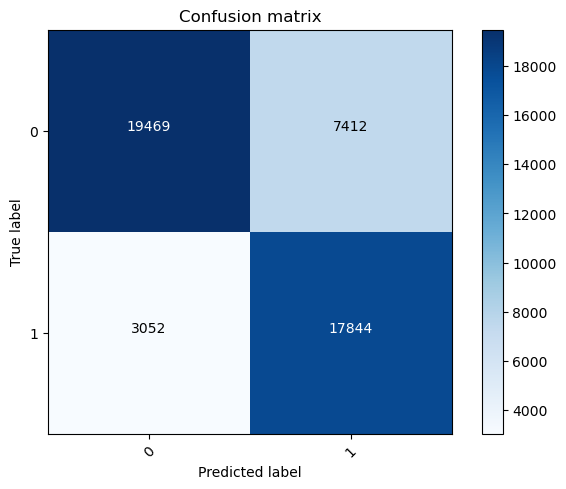

In [19]:
%%time
best_lgb_param = {'n_estimators': 2277, 
                  'lambda_l1': 6.584943102234229, 
                  'lambda_l2': 0.946172984262093, 
                  'num_leaves': 7, 
                  'feature_fraction': 0.4522445204610749, 
                  'bagging_fraction': 0.8463107712205676, 
                  'bagging_freq': 5, 
                  'min_child_samples': 23, 
                  'class_weight': 'balanced'
                 }


model = LGBMClassifier(**best_lgb_param)
model.fit(x_train, y_train)
test_pred = model.predict_proba(x_test)[:,1]
metrics(y_test, test_pred)

Обучим данную модель на всем датасете для подготовки итоговых прогнозов

[LightGBM] [Warning] feature_fraction is set=0.4522445204610749, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4522445204610749
[LightGBM] [Warning] lambda_l1 is set=6.584943102234229, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.584943102234229
[LightGBM] [Warning] lambda_l2 is set=0.946172984262093, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.946172984262093
[LightGBM] [Warning] bagging_fraction is set=0.8463107712205676, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8463107712205676
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.4522445204610749, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4522445204610749
[LightGBM] [Warning] lambda_l1 is set=6.584943102234229, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.584943102234229
[LightGBM] [Warning] lambda_l2 is set=0.946

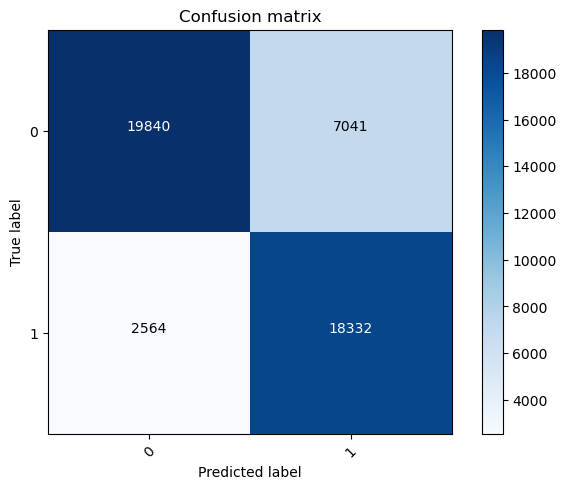

In [7]:
model = LGBMClassifier(**best_lgb_param)
model.fit(x, y)
test_pred = model.predict_proba(x_test)[:,1]
metrics(y_test, test_pred)

## XGBClassifier

precision: 0.7189827896223991
recall: 0.8036944869831547
f1_score: 0.7589822388936592
accuracy_score: 0.7767545053059003
roc_auc: 0.8633015629175677
Wall time: 4.25 s


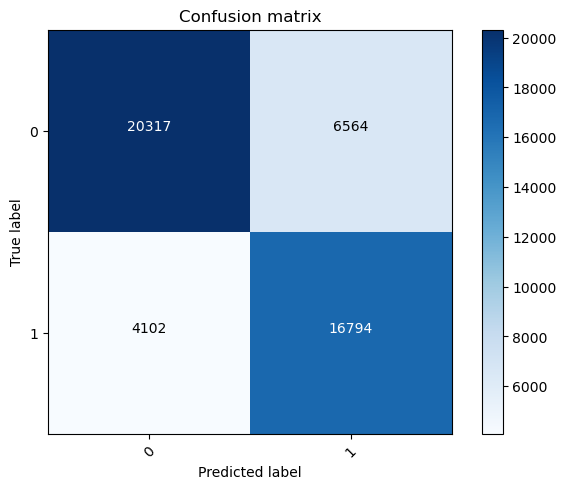

In [20]:
%%time

model = XGBClassifier()
model.fit(x_train, y_train)
test_pred = model.predict_proba(x_test)[:,1]
metrics(y_test, test_pred)

In [21]:
%%time

def objective(trial):    
    params = {
        'max_depth': trial.suggest_int('max_depth', 2, 15),
        'subsample': trial.suggest_discrete_uniform('subsample', 0.6, 1.0, 0.05),
        'n_estimators': trial.suggest_int('n_estimators', 50, 2500),
        'eta': trial.suggest_discrete_uniform('eta', 0.01, 0.1, 0.01),
        'reg_alpha': trial.suggest_int('reg_alpha', 1, 50),
        'reg_lambda': trial.suggest_int('reg_lambda', 5, 100),
        'min_child_weight': trial.suggest_int('min_child_weight', 2, 20),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.1, 1.0),
    }
    
    
    xgb = XGBClassifier(**params)
    
    return cross_val_score(xgb,
                           x_train,
                           y_train,
                           n_jobs=-1,
                           cv=3, 
                           scoring="roc_auc"
                          ).mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

trial = study.best_trial

print('roc_auc: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

[I 2023-12-05 21:13:01,357] A new study created in memory with name: no-name-db96d7ca-f3de-4332-b1ca-34bfeb072608
[I 2023-12-05 21:14:22,161] Trial 0 finished with value: 0.8650964409415245 and parameters: {'max_depth': 9, 'subsample': 0.7, 'n_estimators': 1063, 'eta': 0.06999999999999999, 'reg_alpha': 7, 'reg_lambda': 19, 'min_child_weight': 17, 'colsample_bytree': 0.6272937524203808}. Best is trial 0 with value: 0.8650964409415245.
[I 2023-12-05 21:17:33,044] Trial 1 finished with value: 0.8675373961084188 and parameters: {'max_depth': 9, 'subsample': 0.8, 'n_estimators': 1410, 'eta': 0.02, 'reg_alpha': 23, 'reg_lambda': 94, 'min_child_weight': 6, 'colsample_bytree': 0.6175483353751083}. Best is trial 1 with value: 0.8675373961084188.
[I 2023-12-05 21:18:41,091] Trial 2 finished with value: 0.8634802969586778 and parameters: {'max_depth': 10, 'subsample': 0.7, 'n_estimators': 543, 'eta': 0.02, 'reg_alpha': 34, 'reg_lambda': 41, 'min_child_weight': 5, 'colsample_bytree': 0.49577170649

roc_auc: 0.868179986090035
Best hyperparameters: {'max_depth': 6, 'subsample': 0.8, 'n_estimators': 1146, 'eta': 0.03, 'reg_alpha': 8, 'reg_lambda': 75, 'min_child_weight': 19, 'colsample_bytree': 0.585165322227362}
Wall time: 20min 40s


Для иллюстрации приведен расчет для 10 итераций.

Далее используются параметры подобранные на 500.

precision: 0.7307942567127923
recall: 0.8062308575803981
f1_score: 0.7666613574825367
accuracy_score: 0.7853569709274337
roc_auc: 0.870626419819062


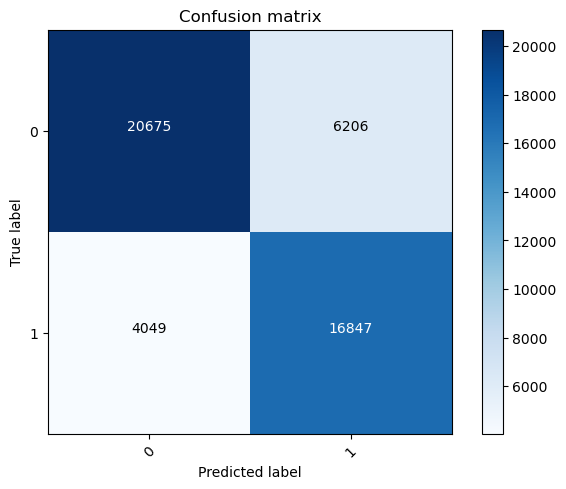

In [22]:
# best for 500

best_xgb_param = {'max_depth': 7, 
                  'subsample': 0.8, 
                  'n_estimators': 2391, 
                  'eta': 0.03, 
                  'reg_alpha': 1, 
                  'reg_lambda': 34, 
                  'min_child_weight': 12, 
                  'colsample_bytree': 0.1708279813778898}

xgb = XGBClassifier(**best_xgb_param)
xgb.fit(x_train, y_train)

test_pred = xgb.predict_proba(x_test)[:,1]
metrics(y_test, test_pred)

Обучим данную модель на всем датасете для подготовки итоговых прогнозов

precision: 0.7605425615163899
recall: 0.8371937212863706
f1_score: 0.7970294774249396
accuracy_score: 0.8135085920003349
roc_auc: 0.9004649245158729


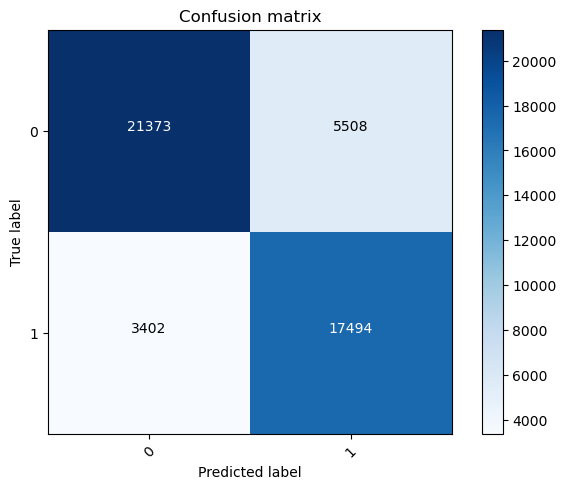

In [23]:
xgb = XGBClassifier(**best_xgb_param)
xgb.fit(x, y)

test_pred = xgb.predict_proba(x_test)[:,1]
metrics(y_test, test_pred)

In [24]:
# строим прогноз на тестовых данных и сохраняем в файл sample_submission

test = pd.read_csv('test.csv')

cols = []
for cl in test.columns:
    cols.append(cl.lower().replace(' ', '_'))
    
test.columns = cols

test['smoking'] = xgb.predict_proba(test.drop('id', axis=1))[:,1]
test[['id', 'smoking']].to_csv('sample_submission_xgb.csv', index=False)

## CatBoostClassifier

precision: 0.7003982197235886
recall: 0.8585375191424196
f1_score: 0.7714470006450225
accuracy_score: 0.7775080059442828
roc_auc: 0.8667428527513327
Wall time: 19.3 s


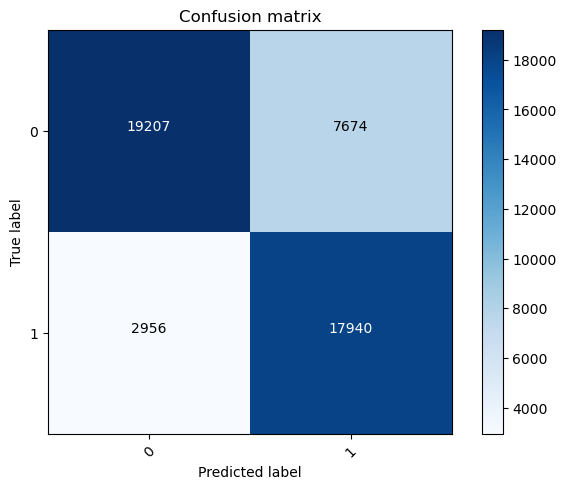

In [25]:
%%time

cb = CatBoostClassifier(class_weights=cw)



cb.fit(x_train, y_train, verbose = False)

test_pred = cb.predict_proba(x_test)[:,1]
metrics(y_test, test_pred)

In [6]:
%%time

def objective(trial):    
    params = {
        
        'depth': trial.suggest_int('depth', 3, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-8, 100.0, log=True),
        'boosting_type': trial.suggest_categorical('boosting_type', ['Ordered', 'Plain']),
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 15),
#         'subsample': trial.suggest_float('subsample', 0.3, 0.95),
        'learning_rate': trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True),
        'random_strength': trial.suggest_float("random_strength", 1e-8, 10.0, log=True),
        'bagging_temperature': trial.suggest_float("bagging_temperature", 0.0, 10.0),
        'od_type': trial.suggest_categorical("od_type", ["IncToDec", "Iter"]),
        'od_wait': trial.suggest_int("od_wait", 10, 50),
        'verbose': False
    }
    
    
    cbc = CatBoostClassifier(**params,
                             class_weights=cw
                            )
    
    return cross_val_score(cbc,
                           x_train,
                           y_train,
                           n_jobs=-1,
                           cv=3, 
                           scoring="roc_auc"
                          ).mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=5)

trial = study.best_trial

print('roc_auc: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

[I 2023-12-06 09:06:35,668] A new study created in memory with name: no-name-c0c4d924-5fe1-47de-aef1-9e328b8a24bb
[I 2023-12-06 09:06:49,055] Trial 0 finished with value: 0.8415726594114359 and parameters: {'depth': 5, 'l2_leaf_reg': 0.009175091478819819, 'boosting_type': 'Plain', 'iterations': 289, 'min_data_in_leaf': 2, 'learning_rate': 0.0045525827389299766, 'random_strength': 1.236247018971969e-08, 'bagging_temperature': 3.099673761693298, 'od_type': 'IncToDec', 'od_wait': 29}. Best is trial 0 with value: 0.8415726594114359.
[I 2023-12-06 09:07:10,359] Trial 1 finished with value: 0.8548572197068519 and parameters: {'depth': 3, 'l2_leaf_reg': 1.6578887607002137, 'boosting_type': 'Plain', 'iterations': 962, 'min_data_in_leaf': 12, 'learning_rate': 0.00833944010039665, 'random_strength': 5.541724801924759e-06, 'bagging_temperature': 3.4028705929499203, 'od_type': 'Iter', 'od_wait': 11}. Best is trial 1 with value: 0.8548572197068519.
[I 2023-12-06 09:08:03,560] Trial 2 finished with 

roc_auc: 0.8649190348333269
Best hyperparameters: {'depth': 4, 'l2_leaf_reg': 0.017520012224226538, 'boosting_type': 'Plain', 'iterations': 756, 'min_data_in_leaf': 8, 'learning_rate': 0.05854270174646246, 'random_strength': 2.531850377047912e-05, 'bagging_temperature': 9.287055539882154, 'od_type': 'IncToDec', 'od_wait': 26}
Wall time: 3min 32s


Для иллюстрации приведен расчет для 5 итераций.

Далее используются параметры подобранные на 500.

precision: 0.6907353836784409
recall: 0.8684437212863706
f1_score: 0.7694623473541384
accuracy_score: 0.7724009460619127
roc_auc: 0.8615537516236981
Wall time: 11.6 s


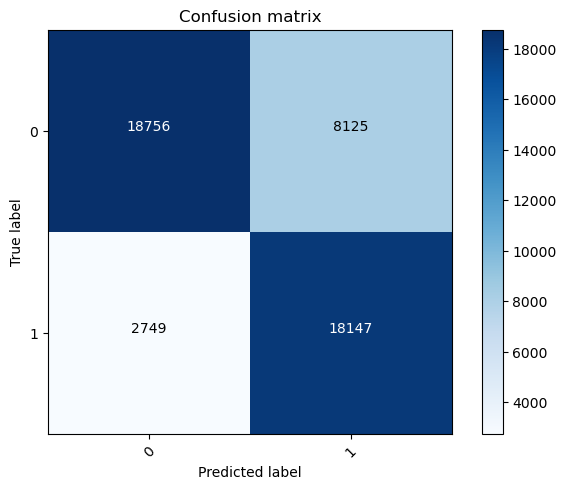

In [7]:
%%time

best_cb_param = {'depth': 5, 
                 'l2_leaf_reg': 97.96341503720109, 
                 'boosting_type': 'Plain', 
                 'iterations': 809, 
                 'min_data_in_leaf': 5, 
                 'subsample': 0.31464410658791775, 
                 'learning_rate': 0.020114534345879145, 
                 'random_strength': 0.06025025168848249, 
                 'bagging_temperature': 4.096407962455776, 
                 'od_type': 'IncToDec', 'od_wait': 31}

cat_grid_model = CatBoostClassifier(**best_cb_param,
                                    class_weights=cw,
                                   )

cat_grid_model.fit(x_train,
                   y_train,
                   verbose = False
                  )

test_pred = cat_grid_model.predict_proba(x_test)[:,1]
metrics(y_test, test_pred)

precision: 0.694331983805668
recall: 0.8699751148545176
f1_score: 0.7722927906877947
accuracy_score: 0.7756242543483266
roc_auc: 0.8650143184671959


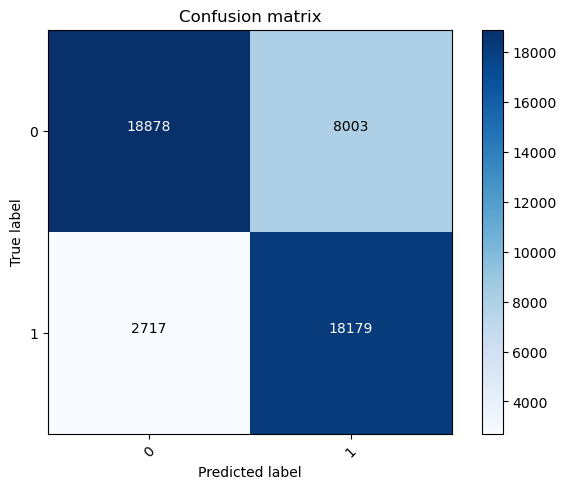

In [8]:
# Обучаем модель с лучшими параметрами на всем датасете

cat_grid_model = CatBoostClassifier(**best_cb_param, class_weights=cw,)

cat_grid_model.fit(x,
                   y,
                   verbose = False
                  )

test_pred = cat_grid_model.predict_proba(x_test)[:,1]
metrics(y_test, test_pred)

## RandomForestClassifier

Для разнообразия для подбора параметрой и используем не Optuna, а  RandomizedSearchCV

In [10]:
%%time
from sklearn.model_selection import RandomizedSearchCV
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
max_features = ['log2', 'sqrt']
max_depth = [int(x) for x in np.linspace(start = 1, stop = 15, num = 15)]
min_samples_split = [int(x) for x in np.linspace(start = 2, stop = 50, num = 10)]
min_samples_leaf = [int(x) for x in np.linspace(start = 2, stop = 50, num = 10)]
bootstrap = [True, False]
param_dist = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               'class_weight': ['balanced'],
               'criterion': ['entropy', 'log_loss', 'gini']
              }

model = RandomForestClassifier()

rs = RandomizedSearchCV(model,
                        param_dist,
                        n_iter = 5,
                        cv = 3,
                        verbose = 1,
                        n_jobs=-1,
                        scoring="roc_auc",
                        random_state=0)
rs.fit(x_train, y_train)
rs.best_params_

Fitting 3 folds for each of 5 candidates, totalling 15 fits
Wall time: 4min 5s


{'n_estimators': 300,
 'min_samples_split': 28,
 'min_samples_leaf': 50,
 'max_features': 'sqrt',
 'max_depth': 14,
 'criterion': 'entropy',
 'class_weight': 'balanced',
 'bootstrap': False}

Для иллюстрации приведен расчет для 5 итераций.

Далее используются параметры подобранные на 500.

precision: 0.6832391149713601
recall: 0.8733728943338438
f1_score: 0.7666939735753145
accuracy_score: 0.7675241224857149
roc_auc: 0.855937230695118


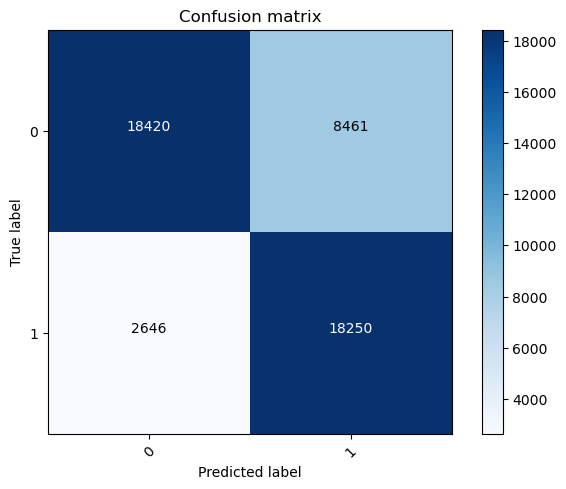

In [11]:
best_rf_param = {'n_estimators': 400,
 'min_samples_split': 50,
 'min_samples_leaf': 12,
 'max_features': 'log2',
 'max_depth': 14,
 'criterion': 'gini',
 'class_weight': 'balanced',
 'bootstrap': True}

rf = RandomForestClassifier(**best_rf_param)
rf.fit(x_train, y_train)

test_pred = rf.predict_proba(x_test)[:,1]

metrics(y_test, test_pred)

precision: 0.7063931726306333
recall: 0.9031393568147014
f1_score: 0.7927413257162059
accuracy_score: 0.7934571027900454
roc_auc: 0.8876063881574814


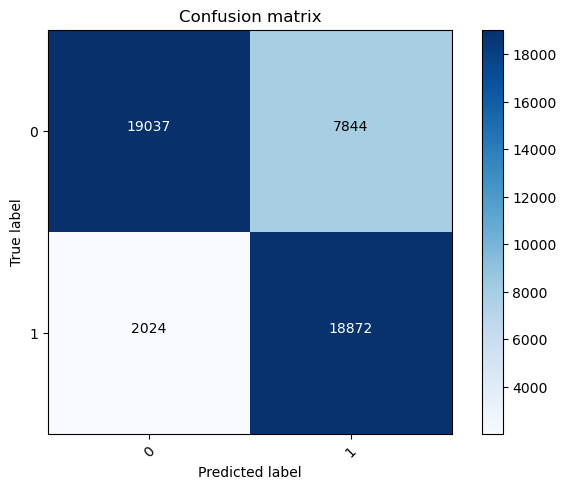

In [12]:
# Обучаем модель с лучшими параметрами на всем датасете

rf = RandomForestClassifier(**best_rf_param, n_jobs=-1)
rf.fit(x, y)

test_pred = rf.predict_proba(x_test)[:,1]

metrics(y_test, test_pred)

In [14]:
test = pd.read_csv('test.csv')
test['defects'] = rf.predict_proba(test.drop('id', axis=1))[:,1]
test[['id', 'defects']].to_csv('sample_submission_rf.csv', index=False)

## AdaBoostClassifier

precision: 0.712832108535896
recall: 0.7845042113323124
f1_score: 0.746952817077894
accuracy_score: 0.7675241224857149
roc_auc: 0.8501658777073908
Wall time: 6.47 s


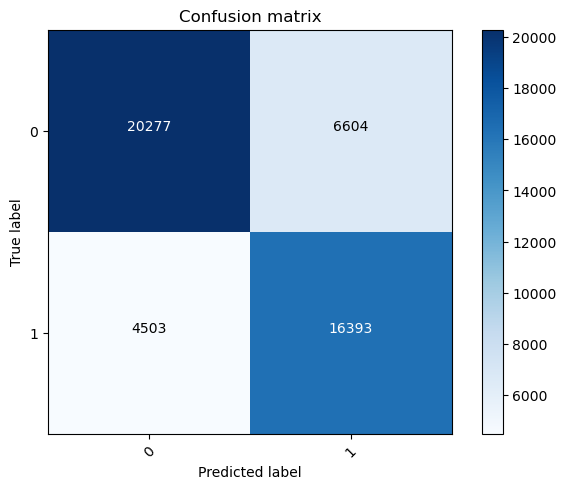

In [6]:
%%time

abd_model = AdaBoostClassifier().fit(x_train, y_train)

test_pred = abd_model.predict_proba(x_test)[:,1]
metrics(y_test, test_pred)

In [7]:
%%time

def objective(trial):    
    param = {'n_estimators': trial.suggest_int("n_estimators", 50, 2000),
             'learning_rate': trial.suggest_float("learning_rate", 0.001, 1.0, log=True),
             'algorithm': trial.suggest_categorical('algorithm',['SAMME','SAMME.R'])
            }


        
    adb = AdaBoostClassifier(**param, random_state=42)

    return cross_val_score(adb,
                           x_train, 
                           y_train,
                           n_jobs=-1,
                           cv=4, 
                           scoring="roc_auc"
                          ).mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=5)

trial = study.best_trial

print('roc_auc: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

[I 2023-12-06 09:58:37,273] A new study created in memory with name: no-name-bdcdff60-3733-43cd-8dbc-71344dd1ab0e
[I 2023-12-06 10:00:44,706] Trial 0 finished with value: 0.8012028006957269 and parameters: {'n_estimators': 1085, 'learning_rate': 0.0016557757043616436, 'algorithm': 'SAMME'}. Best is trial 0 with value: 0.8012028006957269.
[I 2023-12-06 10:01:42,046] Trial 1 finished with value: 0.802227592424221 and parameters: {'n_estimators': 517, 'learning_rate': 0.004367651041918084, 'algorithm': 'SAMME'}. Best is trial 1 with value: 0.802227592424221.
[I 2023-12-06 10:02:32,963] Trial 2 finished with value: 0.8423859900231567 and parameters: {'n_estimators': 461, 'learning_rate': 0.12266779548444812, 'algorithm': 'SAMME'}. Best is trial 2 with value: 0.8423859900231567.
[I 2023-12-06 10:05:23,516] Trial 3 finished with value: 0.8532429267697414 and parameters: {'n_estimators': 1557, 'learning_rate': 0.7644177198662355, 'algorithm': 'SAMME'}. Best is trial 3 with value: 0.8532429267

roc_auc: 0.8564604363852717
Best hyperparameters: {'n_estimators': 506, 'learning_rate': 0.23612465294886165, 'algorithm': 'SAMME.R'}
Wall time: 7min 46s


Для иллюстрации приведен расчет для 5 итераций.

Далее используются параметры подобранные на 500.

precision: 0.7145008605851979
recall: 0.7946496937212864
f1_score: 0.7524469820554649
accuracy_score: 0.7713125562509157
roc_auc: 0.8545995294159335


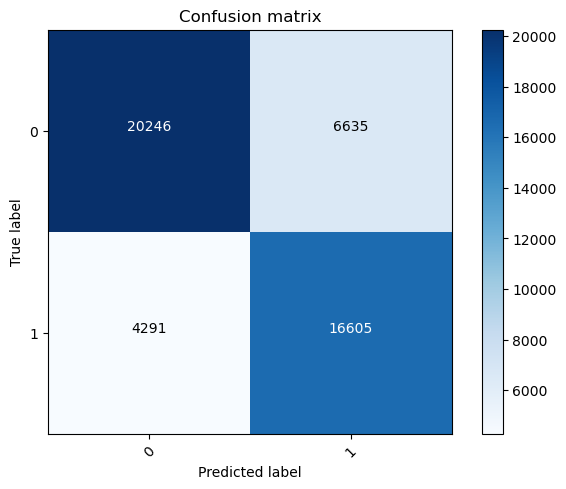

In [8]:
best_adb_param = {'n_estimators': 1890, 'learning_rate': 0.08752018796993234, 'algorithm': 'SAMME.R'}

abd_model = AdaBoostClassifier(**best_adb_param).fit(x_train, y_train)

test_pred = abd_model.predict_proba(x_test)[:,1]
metrics(y_test, test_pred)

precision: 0.7159972418548526
recall: 0.7950803981623277
f1_score: 0.7534693877551019
accuracy_score: 0.7724428072084895
roc_auc: 0.8561997063741827


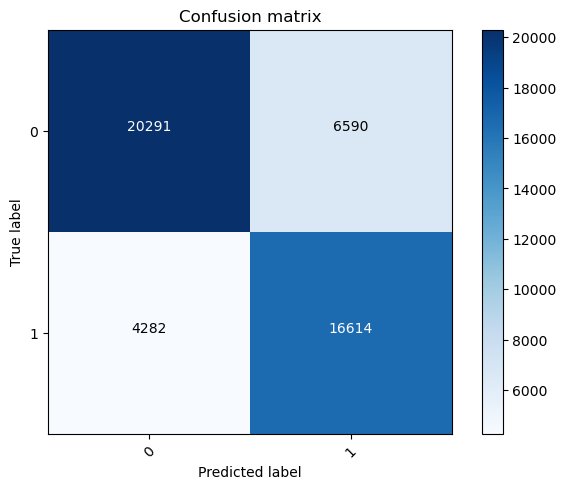

In [10]:
# обучим модель на всем датасете

abd_model = AdaBoostClassifier(**best_adb_param).fit(x, y)
test_pred = abd_model.predict_proba(x_test)[:,1]
metrics(y_test, test_pred)

## LogisticRegression

precision: 0.6758679446219382
recall: 0.7592840735068913
f1_score: 0.7151517883302156
accuracy_score: 0.7354584842078824
roc_auc: 0.8125596789730565


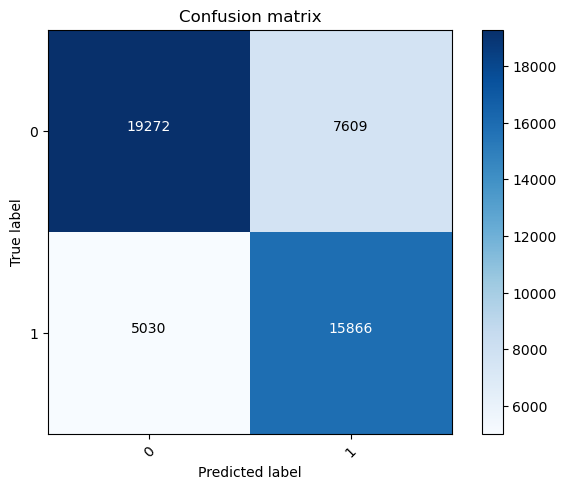

In [11]:
lr_model = LogisticRegression(n_jobs=-1, class_weight='balanced')
lr_model.fit(x_train, y_train)

test_pred = lr_model.predict_proba(x_test)[:,1]
metrics(y_test, test_pred)

#### Данный тип моделей чувствителен к масштабу признаков.
Попробуем провести преобразование.

##### Логарифм

precision: 0.6862510322047894
recall: 0.7954153905053599
f1_score: 0.7368117740934481
accuracy_score: 0.7514703727735103
roc_auc: 0.8296654116409952


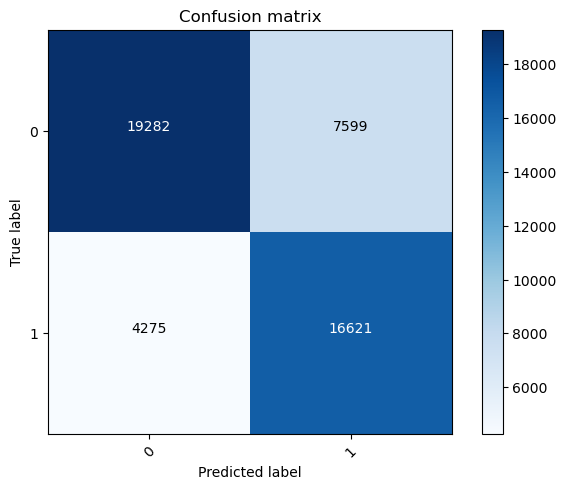

In [14]:

transformer = FunctionTransformer(np.log1p, validate=True)

x_train_log = pd.DataFrame(transformer.transform(x_train), columns=x_train.columns)
x_test_log = pd.DataFrame(transformer.transform(x_test), columns=x_test.columns)

lr_model = LogisticRegression(n_jobs=-1, class_weight='balanced')
lr_model.fit(x_train_log, y_train)

test_pred = lr_model.predict_proba(x_test_log)[:,1]
metrics(y_test, test_pred)

##### StandardScaler

precision: 0.6808228000966106
recall: 0.8093893568147014
f1_score: 0.7395601031964667
accuracy_score: 0.7506750109885509
roc_auc: 0.8312571179664123


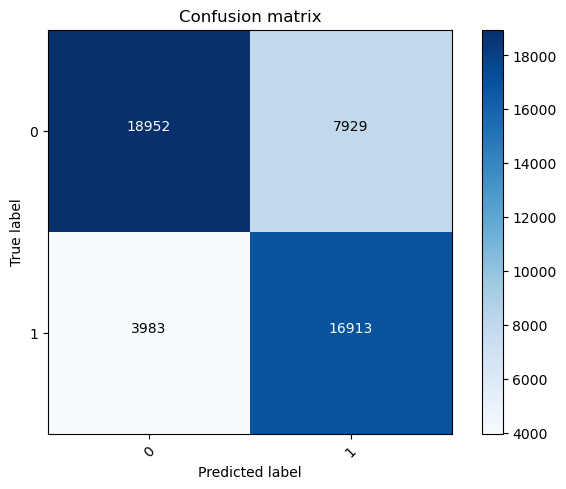

In [15]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(x_train)
x_train_scaled = pd.DataFrame(scaler.transform(x_train), columns=x_train.columns)
x_test_scaled = pd.DataFrame(scaler.transform(x_test), columns=x_test.columns)

lr_model = LogisticRegression(n_jobs=7, class_weight='balanced')
lr_model.fit(x_train_scaled, y_train)

test_pred = lr_model.predict_proba(x_test_scaled)[:,1]
metrics(y_test, test_pred)

##### Log + StandardScaler

precision: 0.6891733634858458
recall: 0.8167113323124043
f1_score: 0.747541558071793
accuracy_score: 0.7587332817045859
roc_auc: 0.8395157891456606


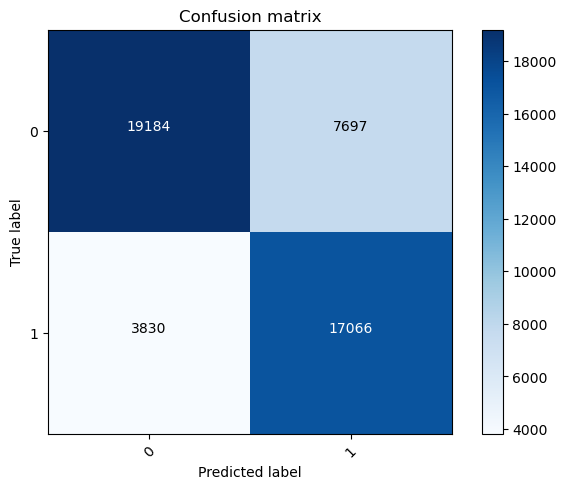

In [16]:
scaler_log = StandardScaler().fit(x_train_log)
x_train_scaled_log = pd.DataFrame(scaler_log.transform(x_train_log), columns=x_train.columns)
x_test_scaled_log = pd.DataFrame(scaler_log.transform(x_test_log), columns=x_test.columns)

lr_model = LogisticRegression(n_jobs=7, class_weight='balanced')
lr_model.fit(x_train_scaled_log, y_train)

test_pred = lr_model.predict_proba(x_test_scaled_log)[:,1]
metrics(y_test, test_pred)

Log + StandartScaler дает лучший результат. Пробуем подбор параметров.

In [18]:
%%time

def objective(trial):    
    param = {
        "solver": trial.suggest_categorical("solver", ["lbfgs", "liblinear", "newton-cg", "sag", "saga"]),
        "max_iter": trial.suggest_int('max_iter', 70, 5000),
        "l1_ratio": trial.suggest_float ('l1_ratio', 0, 1, log=False),
        "tol" : trial.suggest_float('tol' , 1e-6 , 1e-3),
        "C": trial.suggest_float('C', 1e-10, 1000, log=True)

    }


        
    lr_model = LogisticRegression(**param, n_jobs=-1, class_weight='balanced')

    return cross_val_score(lr_model,
                           x_train_scaled_log, 
                           y_train,
                           n_jobs=-1,
                           cv=4, 
                           scoring="roc_auc"
                          ).mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=5)

trial = study.best_trial

print('roc_auc: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

[I 2023-12-06 11:33:33,554] A new study created in memory with name: no-name-51267a82-99a8-4fea-9499-014e307b3926
[I 2023-12-06 11:33:35,331] Trial 0 finished with value: 0.8422806174954853 and parameters: {'solver': 'newton-cg', 'max_iter': 3335, 'l1_ratio': 0.11710323431690028, 'tol': 1.1567802277461329e-05, 'C': 0.009342390468059465}. Best is trial 0 with value: 0.8422806174954853.
[I 2023-12-06 11:33:36,048] Trial 1 finished with value: 0.797482715114139 and parameters: {'solver': 'newton-cg', 'max_iter': 3678, 'l1_ratio': 0.3213598628316928, 'tol': 0.00030569193860202165, 'C': 7.359638033383761e-10}. Best is trial 0 with value: 0.8422806174954853.
[I 2023-12-06 11:33:37,730] Trial 2 finished with value: 0.8423586753687029 and parameters: {'solver': 'newton-cg', 'max_iter': 4284, 'l1_ratio': 0.339219094758788, 'tol': 0.0006554118914910936, 'C': 1.3889553809680704}. Best is trial 2 with value: 0.8423586753687029.
[I 2023-12-06 11:33:38,498] Trial 3 finished with value: 0.84235603062

roc_auc: 0.8423586753687029
Best hyperparameters: {'solver': 'newton-cg', 'max_iter': 4284, 'l1_ratio': 0.339219094758788, 'tol': 0.0006554118914910936, 'C': 1.3889553809680704}
Wall time: 6.35 s


precision: 0.6891733634858458
recall: 0.8167113323124043
f1_score: 0.747541558071793
accuracy_score: 0.7587332817045859
roc_auc: 0.8395150236197847
Wall time: 1.69 s


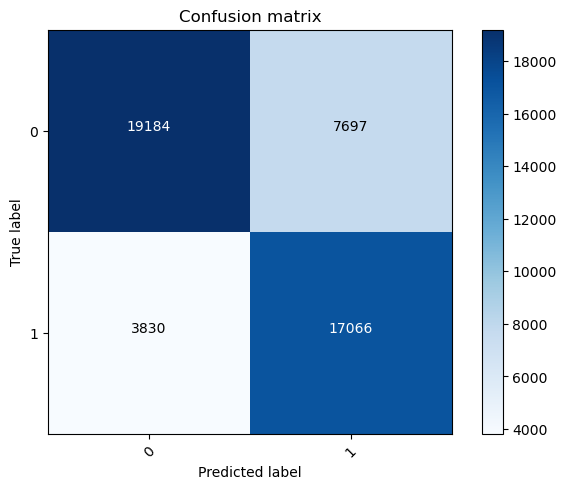

In [20]:
%%time
best_lr_hyperparameters = {'solver': 'lbfgs', 'max_iter': 422, 'l1_ratio': 0.6474120203335338, 'tol': 0.000729722445321157, 'C': 0.4813894097529452}
lr_Pipeline = make_pipeline(transformer, scaler_log, LogisticRegression(**best_lr_hyperparameters, n_jobs=-1, class_weight='balanced'))

lr_Pipeline.fit(x_train, y_train)
test_pred = lr_Pipeline.predict_proba(x_test)[:,1]
metrics(y_test, test_pred)

precision: 0.6897011847478872
recall: 0.8162806278713629
f1_score: 0.74767133495518
accuracy_score: 0.7590263097306236
roc_auc: 0.8397406045122131


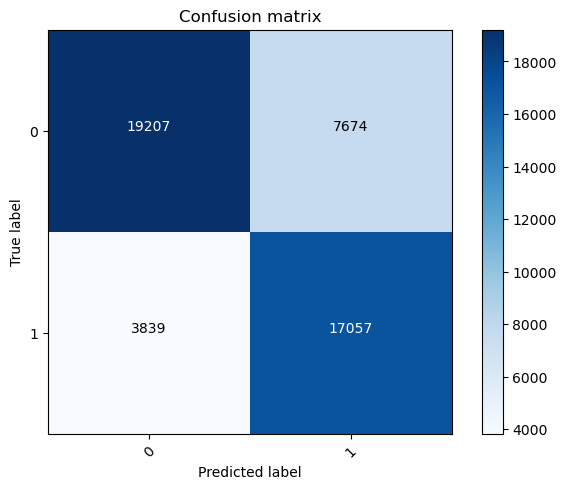

In [35]:
lr_Pipeline = make_pipeline(transformer, scaler_log, LogisticRegression(**best_lr_hyperparameters, n_jobs=-1, class_weight='balanced'))

lr_Pipeline.fit(x, y)
test_pred = lr_Pipeline.predict_proba(x_test)[:,1]
metrics(y_test, test_pred)

## VotingClassifier

0:	learn: 0.6833784	total: 154ms	remaining: 2m 4s
1:	learn: 0.6740141	total: 167ms	remaining: 1m 7s
2:	learn: 0.6651236	total: 181ms	remaining: 48.6s
3:	learn: 0.6567374	total: 195ms	remaining: 39.3s
4:	learn: 0.6487709	total: 209ms	remaining: 33.6s
5:	learn: 0.6411460	total: 222ms	remaining: 29.7s
6:	learn: 0.6339702	total: 232ms	remaining: 26.6s
7:	learn: 0.6271855	total: 244ms	remaining: 24.4s
8:	learn: 0.6207821	total: 253ms	remaining: 22.5s
9:	learn: 0.6145962	total: 264ms	remaining: 21.1s
10:	learn: 0.6086623	total: 277ms	remaining: 20.1s
11:	learn: 0.6030699	total: 287ms	remaining: 19.1s
12:	learn: 0.5977133	total: 299ms	remaining: 18.3s
13:	learn: 0.5926086	total: 312ms	remaining: 17.7s
14:	learn: 0.5878743	total: 325ms	remaining: 17.2s
15:	learn: 0.5833927	total: 338ms	remaining: 16.7s
16:	learn: 0.5790291	total: 350ms	remaining: 16.3s
17:	learn: 0.5749439	total: 367ms	remaining: 16.1s
18:	learn: 0.5708882	total: 381ms	remaining: 15.8s
19:	learn: 0.5672087	total: 394ms	remaini

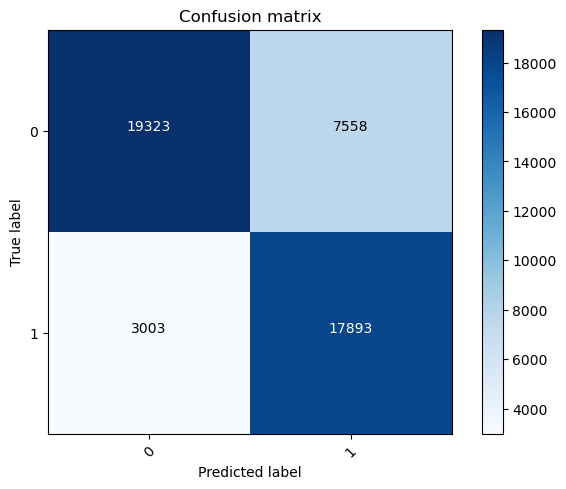

In [44]:
%%time

ensemble = VotingClassifier(
    [('cb', CatBoostClassifier(**best_cb_param, class_weights=cw)),
     ('xgb', XGBClassifier(**best_xgb_param)),
     ('rf', RandomForestClassifier(**best_rf_param)),
     ('lgb', LGBMClassifier(**best_lgb_param)),
     ('lr', lr_Pipeline),
     ('ada', LGBMClassifier(**best_lgb_param)),
    ],
    voting='soft',
    # weights=[0.25, 0.25, 0.25, 0.25]
    )

ensemble.fit(x_train, y_train)


test_pred = ensemble.predict_proba(x_test)[:,1]
metrics(y_test, test_pred)


0:	learn: 0.6833984	total: 17.5ms	remaining: 14.1s
1:	learn: 0.6742144	total: 34.1ms	remaining: 13.8s
2:	learn: 0.6653366	total: 52.9ms	remaining: 14.2s
3:	learn: 0.6569719	total: 70.9ms	remaining: 14.3s
4:	learn: 0.6489919	total: 87.1ms	remaining: 14s
5:	learn: 0.6414351	total: 102ms	remaining: 13.7s
6:	learn: 0.6342145	total: 119ms	remaining: 13.6s
7:	learn: 0.6275086	total: 132ms	remaining: 13.2s
8:	learn: 0.6209152	total: 149ms	remaining: 13.3s
9:	learn: 0.6148216	total: 165ms	remaining: 13.2s
10:	learn: 0.6089001	total: 182ms	remaining: 13.2s
11:	learn: 0.6033432	total: 199ms	remaining: 13.2s
12:	learn: 0.5979385	total: 215ms	remaining: 13.1s
13:	learn: 0.5930192	total: 230ms	remaining: 13.1s
14:	learn: 0.5882118	total: 251ms	remaining: 13.3s
15:	learn: 0.5836905	total: 271ms	remaining: 13.4s
16:	learn: 0.5794739	total: 288ms	remaining: 13.4s
17:	learn: 0.5753333	total: 304ms	remaining: 13.4s
18:	learn: 0.5714709	total: 321ms	remaining: 13.4s
19:	learn: 0.5676282	total: 337ms	rema

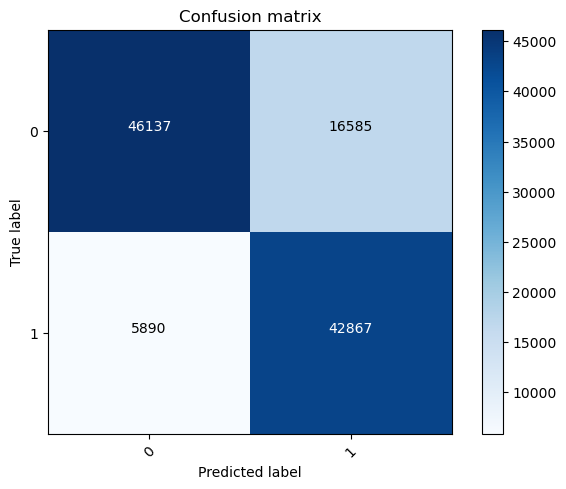

In [45]:
%%time
ensemble.fit(x,y)
train_pred = ensemble.predict_proba(x_train)[:,1]
metrics(y_train, train_pred)

Результаты ансамбля хуже, чем результаты лучшей модели (XGBClassifier), но должны быть более устойчивы.

Попробуем построить ансамль оставив в нем только лучшие модели.

0:	learn: 0.6833784	total: 18.2ms	remaining: 14.7s
1:	learn: 0.6740141	total: 34.8ms	remaining: 14.1s
2:	learn: 0.6651236	total: 51.3ms	remaining: 13.8s
3:	learn: 0.6567374	total: 67.3ms	remaining: 13.5s
4:	learn: 0.6487709	total: 85.1ms	remaining: 13.7s
5:	learn: 0.6411460	total: 103ms	remaining: 13.7s
6:	learn: 0.6339702	total: 119ms	remaining: 13.6s
7:	learn: 0.6271855	total: 135ms	remaining: 13.5s
8:	learn: 0.6207821	total: 150ms	remaining: 13.3s
9:	learn: 0.6145962	total: 166ms	remaining: 13.3s
10:	learn: 0.6086623	total: 183ms	remaining: 13.3s
11:	learn: 0.6030699	total: 199ms	remaining: 13.2s
12:	learn: 0.5977133	total: 219ms	remaining: 13.4s
13:	learn: 0.5926086	total: 239ms	remaining: 13.5s
14:	learn: 0.5878743	total: 259ms	remaining: 13.7s
15:	learn: 0.5833927	total: 280ms	remaining: 13.9s
16:	learn: 0.5790291	total: 301ms	remaining: 14s
17:	learn: 0.5749439	total: 318ms	remaining: 14s
18:	learn: 0.5708882	total: 333ms	remaining: 13.8s
19:	learn: 0.5672087	total: 349ms	remain

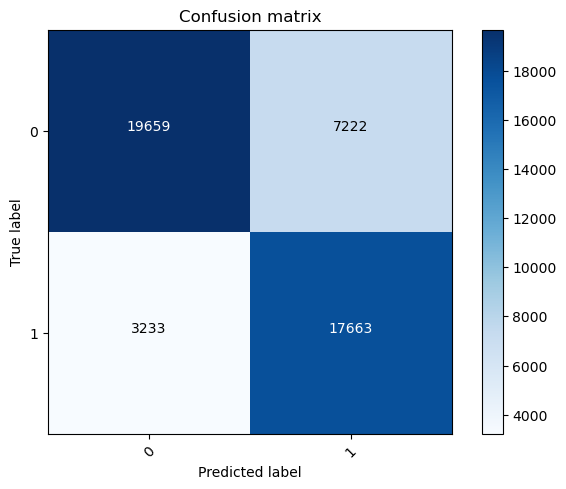

In [46]:
%%time

ensemble2 = VotingClassifier(
    [('cb', CatBoostClassifier(**best_cb_param, class_weights=cw)),
     ('xgb', XGBClassifier(**best_xgb_param)),     
     ('lgb', LGBMClassifier(**best_lgb_param))     
    ],
    voting='soft',    
    )

ensemble2.fit(x_train, y_train)


test_pred = ensemble2.predict_proba(x_test)[:,1]
metrics(y_test, test_pred)

Результат незначительно улучшился, при этом сложность вычислений снизилась.
Остановимся на этом варианте.

Обучим ансамбль на всем датасете.

0:	learn: 0.6833984	total: 19.8ms	remaining: 16s
1:	learn: 0.6742144	total: 41.4ms	remaining: 16.7s
2:	learn: 0.6653366	total: 63ms	remaining: 16.9s
3:	learn: 0.6569719	total: 81.2ms	remaining: 16.3s
4:	learn: 0.6489919	total: 101ms	remaining: 16.2s
5:	learn: 0.6414351	total: 117ms	remaining: 15.7s
6:	learn: 0.6342145	total: 137ms	remaining: 15.7s
7:	learn: 0.6275086	total: 153ms	remaining: 15.3s
8:	learn: 0.6209152	total: 175ms	remaining: 15.6s
9:	learn: 0.6148216	total: 193ms	remaining: 15.4s
10:	learn: 0.6089001	total: 212ms	remaining: 15.4s
11:	learn: 0.6033432	total: 232ms	remaining: 15.4s
12:	learn: 0.5979385	total: 254ms	remaining: 15.5s
13:	learn: 0.5930192	total: 277ms	remaining: 15.8s
14:	learn: 0.5882118	total: 296ms	remaining: 15.7s
15:	learn: 0.5836905	total: 315ms	remaining: 15.6s
16:	learn: 0.5794739	total: 337ms	remaining: 15.7s
17:	learn: 0.5753333	total: 358ms	remaining: 15.7s
18:	learn: 0.5714709	total: 377ms	remaining: 15.7s
19:	learn: 0.5676282	total: 397ms	remaini

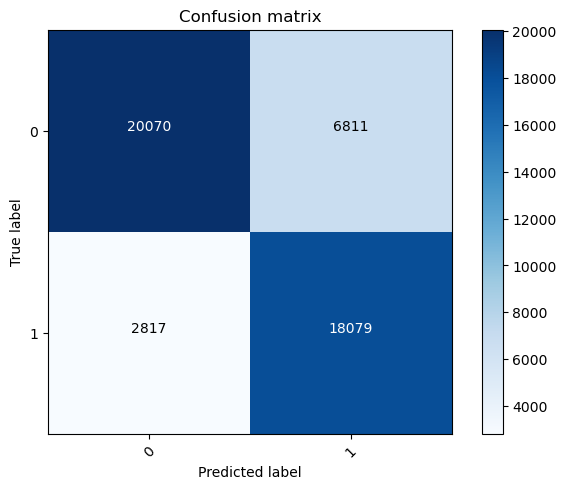

In [48]:
%%time


ensemble2.fit(x, y)
test_pred = ensemble2.predict_proba(x_test)[:,1]
metrics(y_test, test_pred)